In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ummsafiyyah","key":"4c713f1b0b87ad91cb5d8da591fa6ed3"}'}

In [5]:
import os

# Make a hidden folder for your kaggle API key
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the JSON into the kaggle folder
!mv kaggle.json /root/.kaggle/

# Fix permissions so it works
!chmod 600 /root/.kaggle/kaggle.json


In [6]:
# Install kaggle package if not already
!pip install -q kaggle

# Download the competition dataset (this one is zipped)
!kaggle competitions download -c iuss-23-24-automatic-diagnosis-breast-cancer


 80% 234M/293M [00:00<00:00, 586MB/s] 
100% 293M/293M [00:00<00:00, 598MB/s]


In [7]:
import zipfile

with zipfile.ZipFile("iuss-23-24-automatic-diagnosis-breast-cancer.zip", "r") as zip_ref:
    zip_ref.extractall("breast_cancer_data")

# Optional: See what's inside
import os
os.listdir("breast_cancer_data")


['complete_set', 'training_set']

In [8]:
import os

# Check what's in training_set
print("Contents of training_set:")
print(os.listdir("breast_cancer_data/training_set"))

# Check what's in complete_set
print("\nContents of complete_set:")
print(os.listdir("breast_cancer_data/complete_set"))


Contents of training_set:
['benign', 'malignant']

Contents of complete_set:
['testing_set', 'training_set']


In [9]:
import tensorflow as tf
import os

train_dir = "breast_cancer_data/training_set"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',  # 0 = benign, 1 = malignant
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)


Found 1112 files belonging to 2 classes.


In [10]:
val_size = 0.2
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = int(val_size * total_batches)

val_ds = train_ds.take(val_batches)
train_ds = train_ds.skip(val_batches)

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
# Count classes for weights
benign = len(os.listdir("breast_cancer_data/training_set/benign"))
malignant = len(os.listdir("breast_cancer_data/training_set/malignant"))
total = benign + malignant

weight_for_0 = total / (2 * benign)
weight_for_1 = total / (2 * malignant)

class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weight)


Class weights: {0: 0.7029077117572693, 1: 1.7320872274143302}


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5409 - loss: 0.8976 - val_accuracy: 0.8259 - val_loss: 0.3511
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8423 - loss: 0.3691 - val_accuracy: 0.8750 - val_loss: 0.2903
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8389 - loss: 0.3336 - val_accuracy: 0.8839 - val_loss: 0.2499
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8764 - loss: 0.2752 - val_accuracy: 0.8973 - val_loss: 0.2519
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8884 - loss: 0.2411 - val_accuracy: 0.9062 - val_loss: 0.2237
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8947 - loss: 0.2458 - val_accuracy: 0.9062 - val_loss: 0.2081
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9112 - loss: 0.2095 - val_accuracy: 0.9152 - val_loss: 0.2019
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9117 - loss: 0.2083 - val_accuracy: 0.9152 - val_loss:

<Figure size 600x600 with 0 Axes>

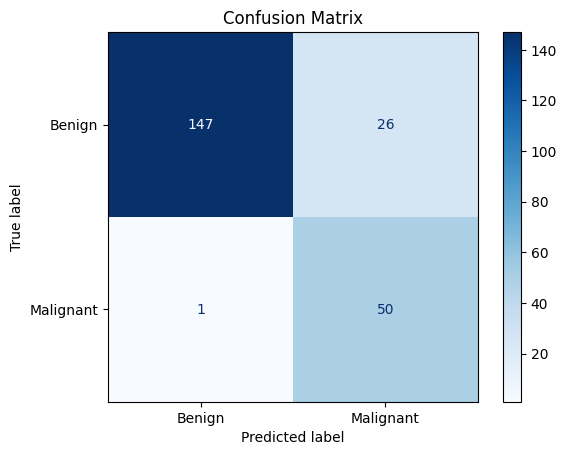

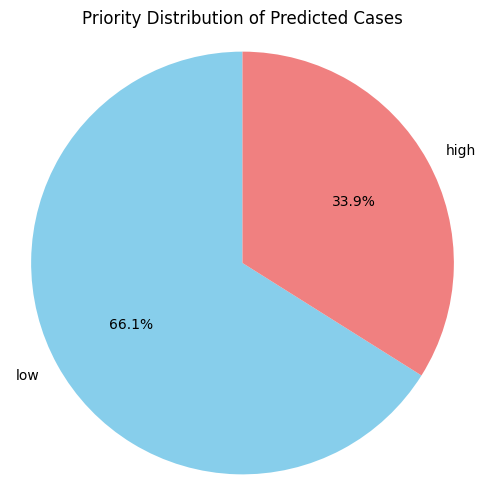

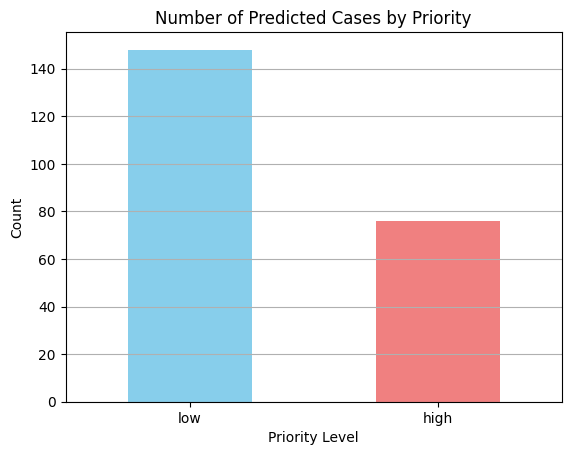

In [12]:
# 🧠 Model with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🚀 Initial training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight
)

# 🔁 Fine-tune the base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10,
    class_weight=class_weight
)

# 🧪 Make predictions on val_ds
import numpy as np
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in val_ds])

# 🧾 Prediction summary
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction Summary (0 = benign, 1 = malignant):", dict(zip(unique, counts)))

# 📈 Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 📊 Priority mapping
import pandas as pd
label_map = {0: "benign", 1: "malignant"}
results = [label_map[p] for p in y_pred]
priority_map = {"benign": "low", "malignant": "high"}
priorities = [priority_map[r] for r in results]

df_preds = pd.DataFrame({
    "Prediction": results,
    "Priority": priorities
})

# 🥧 Pie Chart
priority_counts = df_preds['Priority'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(priority_counts, labels=priority_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['skyblue', 'lightcoral'])
plt.title('Priority Distribution of Predicted Cases')
plt.axis('equal')
plt.show()

# 📊 Bar Chart
priority_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Number of Predicted Cases by Priority')
plt.ylabel('Count')
plt.xlabel('Priority Level')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()







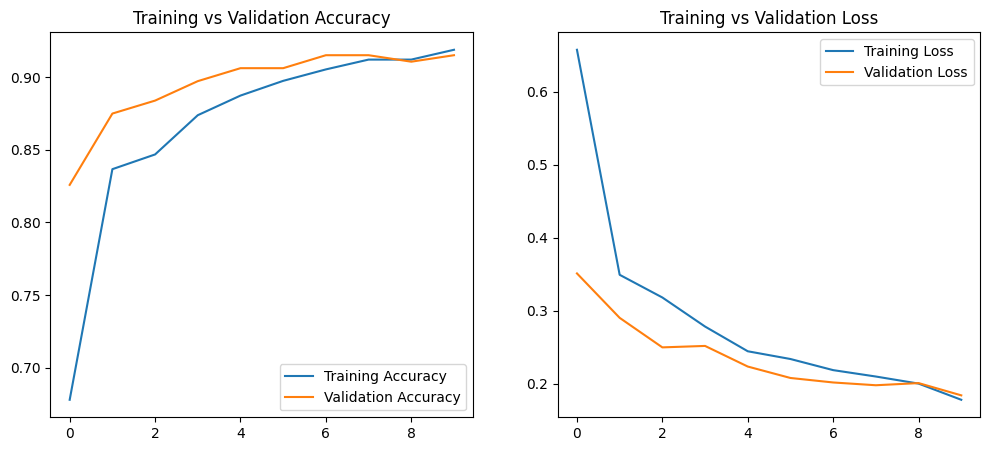

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


In [15]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Convert y_true from one-hot to integers
y_true_int = np.argmax(y_true, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Accuracy and F1 score
acc = accuracy_score(y_true_int, y_pred_int)
f1 = f1_score(y_true_int, y_pred_int, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8795
F1 Score: 0.8866
